In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import datetime
import logging
import warnings
from pathlib import Path 

import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import pandas_profiling as pp 


warnings.filterwarnings('ignore')

In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)-15s %(levelname)s: %(message)s')
# 数据集目录
data_path = Path(r'/Users/liuzhi/datasets/tc_金融风控-贷款违约预测')

In [3]:
train = pd.read_csv(f"{data_path}/train.csv")
testA = pd.read_csv(f"{data_path}/testA.csv")
logging.info(f"train shape: {train.shape}")
logging.info(f"testA shape: {testA.shape}")
train.head()

2021-01-08 15:29:42,866 INFO: train shape: (800000, 47)
2021-01-08 15:29:42,867 INFO: testA shape: (200000, 46)


,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0,35000.0,5,19.52,917.97,E,E2,320.0,2 years,2,...,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,1,18000.0,5,18.49,461.90,D,D2,219843.0,5 years,0,...,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
2,2,12000.0,5,16.99,298.17,D,D3,31698.0,8 years,0,...,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,3,11000.0,3,7.26,340.96,A,A4,46854.0,10+ years,1,...,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
4,4,3000.0,3,12.99,101.07,C,C2,54.0,NaN,1,...,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0


### EDA
1.EDA价值主要在于熟悉了解整个数据集的基本情况（缺失值，异常值），对数据集进行验证是否可以进行接下来的机器学习或者深度学习建模.

2.了解变量间的相互关系、变量与预测值之间的存在关系。

3.为特征工程做准备

In [6]:
# 通过info()来熟悉数据类型
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  800000 non-null  int64  
 1   loanAmnt            800000 non-null  float64
 2   term                800000 non-null  int64  
 3   interestRate        800000 non-null  float64
 4   installment         800000 non-null  float64
 5   grade               800000 non-null  object 
 6   subGrade            800000 non-null  object 
 7   employmentTitle     799999 non-null  float64
 8   employmentLength    753201 non-null  object 
 9   homeOwnership       800000 non-null  int64  
 10  annualIncome        800000 non-null  float64
 11  verificationStatus  800000 non-null  int64  
 12  issueDate           800000 non-null  object 
 13  isDefault           800000 non-null  int64  
 14  purpose             800000 non-null  int64  
 15  postCode            799999 non-nul

### 查看数据集中特征缺失值，唯一值等情况
1.纵向了解哪些列存在 “nan”, 并可以把nan的个数打印，主要的目的在于查看某一列nan存在的个数是否真的很大，如果nan存在的过多，说明这一列对label的影响几乎不起作用了，可以考虑删掉。如果缺失值很小一般可以选择填充。

2.另外可以横向比较，如果在数据集中，某些样本数据的大部分列都是缺失的且样本足够的情况下可以考虑删除。

3.比赛大杀器lgb模型可以自动处理缺失值

In [4]:
def get_feature_null_more_than_half(df):
    r'''缺失值超过一半的特征'''
    feature_null_more_than_half = {}
    have_null_feature_dict = (df.isnull().sum()/len(df)).to_dict()
    for k,v in have_null_feature_dict.items():
        if v > 0.5:
            feature_null_more_than_half[k] = v
    return feature_null_more_than_half
    
def get_one_value_featrue(df):
    r'''获取全为空、或只有一个值得列'''
    return [col for col in df.columns if df[col].nunique() <= 1]


def plot_missing(df):
    r'''展示具体缺失值得缺失率'''
    missing = df.isnull().sum()/len(df)
    missing = missing[missing>0]
    missing.sort_values(inplace=True)
    missing.plot.bar()

2021-01-08 15:31:58,244 INFO: Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-01-08 15:31:58,244 INFO: NumExpr defaulting to 8 threads.
2021-01-08 15:31:58,247 INFO: 
缺失值超过一半的特征:
{}



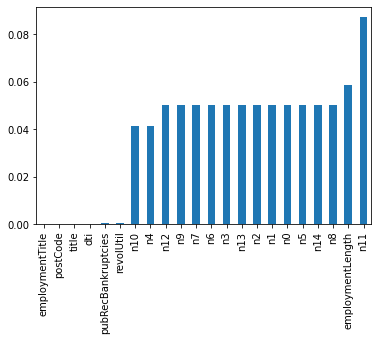

In [5]:
# 缺失值超过一半的特征
logging.info(f"\n缺失值超过一半的特征:\n{get_feature_null_more_than_half(train)}\n")

# 展示具体缺失值得缺失率
plot_missing(train)

In [6]:
# 获取全为空、或只有一个值得列
one_value_featrue = get_one_value_featrue(train)
logging.info(f"\n空值或唯一值的列：{one_value_featrue}\n")

2021-01-08 15:31:59,859 INFO: 
空值或唯一值的列：['policyCode']



### 查看特征的数值类型 / 对象类型

1.特征一般都是由类别型特征和数值型特征组成，而数值型特征又分为连续型和离散型。

2.类别型特征有时具有非数值关系，有时也具有数值关系。比如‘grade’中的等级A，B，C等，是否只是单纯的分类，还是A优于其他要结合业务判断。

3.数值型特征本是可以直接入模的，但往往风控人员要对其做分箱，转化为WOE编码进而做标准评分卡等操作。从模型效果上来看，特征分箱主要是为了降低变量的复杂性，减少变量噪音对模型的影响，提高自变量和因变量的相关度。从而使模型更加稳定。

In [7]:
def split_numerical_and_category_features(df):
    r'''拆分数值列、类别列'''
    numerical_features = list(df.select_dtypes(exclude=['object']).columns)
    category_features = list(filter(lambda x: x not in numerical_features, list(df.columns)))
    return numerical_features, category_features

def split_serial_noserial_of_numerical_features(df, numerical_features, THRESH=10):
    r'''划分数值型变量中的连续变量和离散型变量'''
    numerical_serial_features = []
    numerical_noserial_features = []
    for fea in numerical_features:
        nclasses = df[fea].nunique()
        if nclasses <= THRESH:
            numerical_noserial_features.append(fea)
            continue
        numerical_serial_features.append(fea)
    return numerical_serial_features, numerical_noserial_features

In [8]:
numerical_features, category_features = split_numerical_and_category_features(train)
logging.info(f"\n数值列：\n{numerical_features}\n\n类别列：\n{category_features}\n")

2021-01-08 15:32:00,942 INFO: 
数值列：
['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'employmentTitle', 'homeOwnership', 'annualIncome', 'verificationStatus', 'isDefault', 'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc', 'initialListStatus', 'applicationType', 'title', 'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14']

类别列：
['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']



In [9]:
numerical_serial_features, numerical_noserial_features = split_serial_noserial_of_numerical_features(train, numerical_features)
logging.info(f"\n连续变量列：\n{numerical_serial_features}\n\n离散型变量列：\n{numerical_noserial_features}\n")

2021-01-08 15:32:01,783 INFO: 
连续变量列：
['id', 'loanAmnt', 'interestRate', 'installment', 'employmentTitle', 'annualIncome', 'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc', 'title', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n13', 'n14']

离散型变量列：
['term', 'homeOwnership', 'verificationStatus', 'isDefault', 'initialListStatus', 'applicationType', 'policyCode', 'n11', 'n12']



### 数值类别型变量分析

In [36]:
train['term'].value_counts()  # 离散型变量

3    606902
5    193098
Name: term, dtype: int64

In [35]:
train['homeOwnership'].value_counts()  # 离散型变量

0    395732
1    317660
2     86309
3       185
5        81
4        33
Name: homeOwnership, dtype: int64

In [34]:
train['verificationStatus'].value_counts()  # 离散型变量

1    309810
2    248968
0    241222
Name: verificationStatus, dtype: int64

In [33]:
train['isDefault'].value_counts()  # 离散型变量

0    640390
1    159610
Name: isDefault, dtype: int64

In [32]:
train['initialListStatus'].value_counts()  # 离散型变量

0    466438
1    333562
Name: initialListStatus, dtype: int64

In [31]:
train['applicationType'].value_counts()  # 离散型变量

0    784586
1     15414
Name: applicationType, dtype: int64

In [30]:
train['policyCode'].value_counts()  # 离散型变量，无用，全部一个值

1.0    800000
Name: policyCode, dtype: int64

In [29]:
train['n11'].value_counts()  # 离散型变量，相差悬殊，用不用再分析

0.0    729682
1.0       540
2.0        24
3.0         1
4.0         1
Name: n11, dtype: int64

In [28]:
train['n12'].value_counts()  # 离散型变量，相差悬殊，用不用再分析

0.0    757315
1.0      2281
2.0       115
3.0        16
4.0         3
Name: n12, dtype: int64

### 数值连续型变量分析

1.查看某一个数值型变量的分布，查看变量是否符合正态分布，如果不符合正太分布的变量可以log化后再观察下是否符合正态分布。

2.如果想统一处理一批数据变标准化 必须把这些之前已经正态化的数据提出

3.正态化的原因：一些情况下正态非正态可以让模型更快的收敛，一些模型要求数据正态（eg. GMM、KNN）,保证数据不要过偏态即可，过于偏态可能会影响模型预测结果。

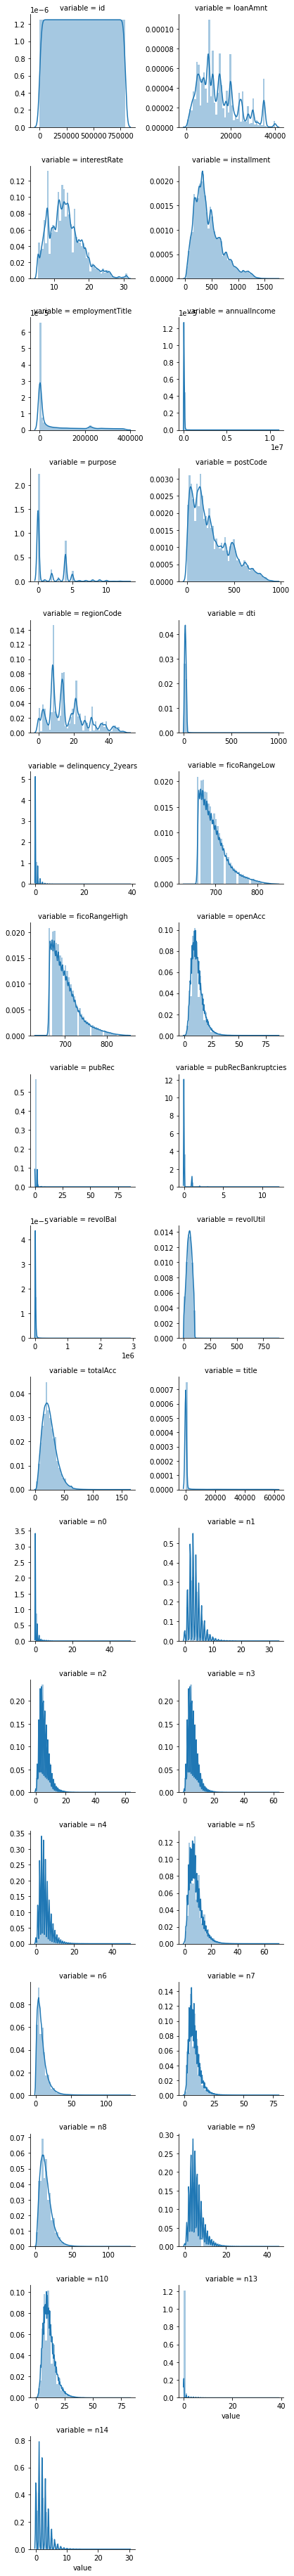

In [38]:
# 每个数字特征得分布可视化
f = pd.melt(train, value_vars=numerical_serial_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

Text(0, 0.5, 'Probability')

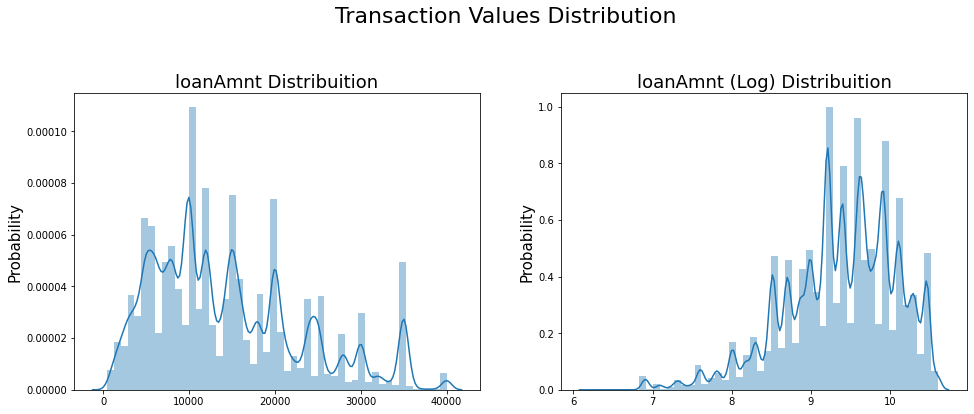

In [42]:
r'''尝试用LOG转换不符合正太分布的变量'''
feature = r'loanAmnt'

plt.figure(figsize=(16,12))
plt.suptitle('Transaction Values Distribution', fontsize=22)
plt.subplot(221)
sub_plot_1 = sns.distplot(train[feature])
sub_plot_1.set_title(f"{feature} Distribuition", fontsize=18)
sub_plot_1.set_xlabel("")
sub_plot_1.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
sub_plot_2 = sns.distplot(np.log(train[feature]))
sub_plot_2.set_title(f"{feature} (Log) Distribuition", fontsize=18)
sub_plot_2.set_xlabel("")
sub_plot_2.set_ylabel("Probability", fontsize=15)

In [43]:
# 类别变量
category_features

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

In [49]:
train['grade'].value_counts()

B    233690
C    227118
A    139661
D    119453
E     55661
F     19053
G      5364
Name: grade, dtype: int64

In [48]:
train['subGrade'].value_counts()

C1    50763
B4    49516
B5    48965
B3    48600
C2    47068
C3    44751
C4    44272
B2    44227
B1    42382
C5    40264
A5    38045
A4    30928
D1    30538
D2    26528
A1    25909
D3    23410
A3    22655
A2    22124
D4    21139
D5    17838
E1    14064
E2    12746
E3    10925
E4     9273
E5     8653
F1     5925
F2     4340
F3     3577
F4     2859
F5     2352
G1     1759
G2     1231
G3      978
G4      751
G5      645
Name: subGrade, dtype: int64

In [47]:
train['employmentLength'].value_counts()

10+ years    262753
2 years       72358
< 1 year      64237
3 years       64152
1 year        52489
5 years       50102
4 years       47985
6 years       37254
8 years       36192
7 years       35407
9 years       30272
Name: employmentLength, dtype: int64

In [45]:
train['issueDate'].value_counts()

2016-03-01    29066
2015-10-01    25525
2015-07-01    24496
2015-12-01    23245
2014-10-01    21461
              ...  
2007-08-01       23
2007-07-01       21
2008-09-01       19
2007-09-01        7
2007-06-01        1
Name: issueDate, Length: 139, dtype: int64

In [44]:
train['earliesCreditLine'].value_counts()

Aug-2001    5567
Aug-2002    5403
Sep-2003    5403
Oct-2001    5258
Aug-2000    5246
            ... 
Nov-1954       1
Oct-2015       1
Aug-1958       1
Sep-1953       1
Jul-1955       1
Name: earliesCreditLine, Length: 720, dtype: int64

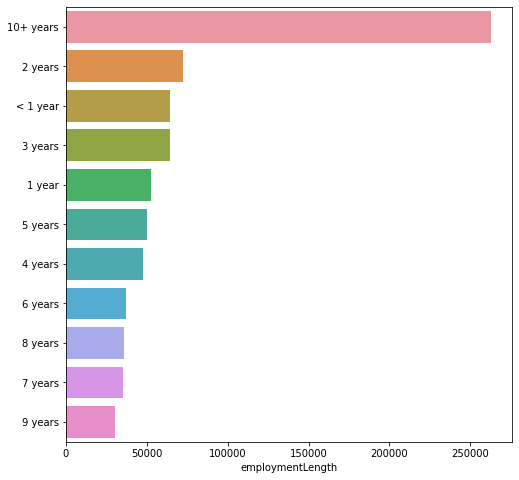

In [50]:
# 单一变量分布可视化

feature = 'employmentLength'

plt.figure(figsize=(8, 8))
sns.barplot(train[feature].value_counts(dropna=False)[:20], train[feature].value_counts(dropna=False).keys()[:20])
plt.show()

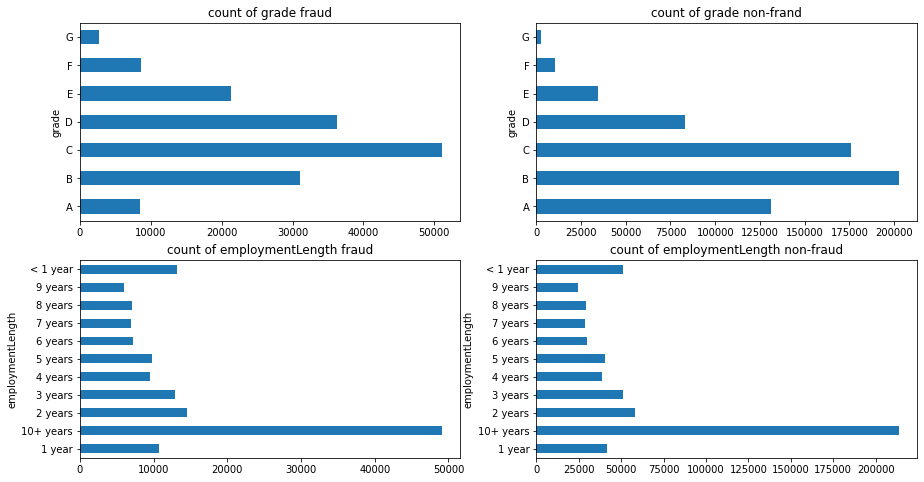

In [53]:
# 根据Y值不同，可视化Feature在不同Y上的分布
feature = 'isDefault'
train_load_fr = train.loc[train[feature] == 1]
train_load_nonfr = train.loc[train[feature] == 0]

fig, ((ax1, ax2), (ax3, ax4))  = plt.subplots(2, 2, figsize=(15, 8))
train_load_fr.groupby('grade')['grade'].count().plot(kind='barh', ax=ax1, title='count of grade fraud')
train_load_nonfr.groupby('grade')['grade'].count().plot(kind='barh', ax=ax2, title='count of grade non-frand')
train_load_fr.groupby('employmentLength')['employmentLength'].count().plot(kind='barh', ax=ax3, title='count of employmentLength fraud')
train_load_nonfr.groupby('employmentLength')['employmentLength'].count().plot(kind='barh', ax=ax4, title='count of employmentLength non-fraud')
plt.show()

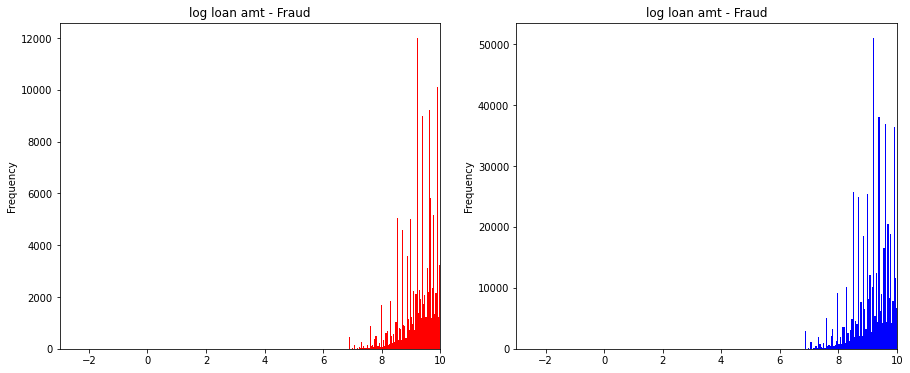

In [56]:
# 查看连续型变量在不同Y值上的分布
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 6))
train.loc[train['isDefault'] == 1]['loanAmnt'].apply(np.log).plot(
    kind='hist',
    bins=100,
    title='log loan amt - Fraud',
    color='r',
    xlim=(-3, 10),
    ax=ax1
)
train.loc[train['isDefault'] == 0]['loanAmnt'].apply(np.log).plot(
    kind='hist',
    bins=100,
    title='log loan amt - Fraud',
    color='b',
    xlim=(-3, 10),
    ax=ax2
)
plt.show()

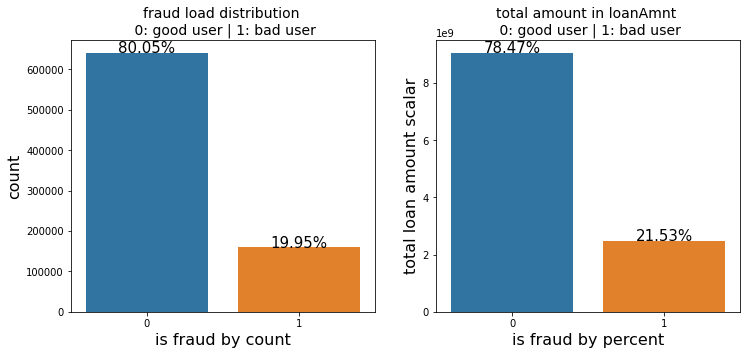

In [59]:
total = len(train)
total_amt = train.groupby(['isDefault'])['loanAmnt'].sum().sum()
plt.figure(figsize=(12, 5))
plt.subplot(121)  # 1代表行， 2代表2个图，1代表绘制第1个图
plot_tr = sns.countplot(x='isDefault', data=train)  # train 'isDefault'这个特征每种类别的数量
plot_tr.set_title('fraud load distribution \n 0: good user | 1: bad user', fontsize=14)
plot_tr.set_xlabel('is fraud by count', fontsize=16)
plot_tr.set_ylabel('count', fontsize=16)
for p in plot_tr.patches:
    height = p.get_height()
    plot_tr.text(p.get_x()+p.get_width()/2.,height+3, f'{height/total*100:1.2f}%', ha='center', fontsize=15)

percent_amt = (train.groupby(['isDefault'])['loanAmnt'].sum())
percent_amt = percent_amt.reset_index()
plt.subplot(122)
plot_tr_2 = sns.barplot(x='isDefault', y='loanAmnt', dodge=True, data=percent_amt)
plot_tr_2.set_title('total amount in loanAmnt \n 0: good user | 1: bad user', fontsize=14)
plot_tr_2.set_xlabel('is fraud by percent', fontsize=16)
plot_tr_2.set_ylabel('total loan amount scalar', fontsize=16)
for p in plot_tr_2.patches:
    height = p.get_height()
    plot_tr_2.text(p.get_x()+p.get_width()/2.,height+3, f'{height/total_amt*100:1.2f}%', ha='center', fontsize=15)
plt.show()

### 时间格式数据处理及查看

In [60]:
# 转化成时间格式 issueDateDT特征表示数据日期离散数据集中日期最早的日期(2007-06-01)的天数
train['issueDate'] = pd.to_datetime(train['issueDate'], format=r'%Y-%m-%d')
startdate = datetime.datetime.strptime('2007-06-01', r'%Y-%m-%d')
train['issueDateDT'] = train['issueDate'].apply(lambda x: x-startdate).dt.days

In [61]:
testA['issueDate'] = pd.to_datetime(testA['issueDate'], format=r'%Y-%m-%d')
startdate = datetime.datetime.strptime('2007-06-01', r'%Y-%m-%d')
testA['issueDateDT'] = testA['issueDate'].apply(lambda x: x-startdate).dt.days

Text(0.5, 1.0, 'Distribution of issueDateDT dates')

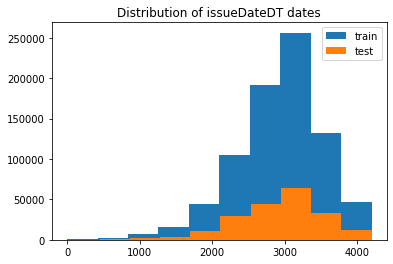

In [62]:
plt.hist(train['issueDateDT'], label='train')
plt.hist(testA['issueDateDT'], label='test')
plt.legend()
plt.title('Distribution of issueDateDT dates')
# train 和 test issueDateDT 日期有重叠， 所以使用基于时间的分割进行验证是不明智的

In [63]:
# 掌握透视图可以更好的了解数据

pivot = pd.pivot_table(train, index=['grade'], columns=['issueDateDT'], values=['loanAmnt'], aggfunc=np.sum)
pivot

loanAmnt                                                         \
issueDateDT     0        30       61       92       122      153       183    
grade                                                                         
A                NaN  53650.0  42000.0  19500.0  34425.0  63950.0   43500.0   
B                NaN  13000.0  24000.0  32125.0   7025.0  95750.0  164300.0   
C                NaN  68750.0   8175.0  10000.0  61800.0  52550.0  175375.0   
D                NaN      NaN   5500.0   2850.0  28625.0      NaN  167975.0   
E             7500.0      NaN  10000.0      NaN  17975.0   1500.0   94375.0   
F                NaN      NaN  31250.0   2125.0      NaN      NaN       NaN   
G                NaN      NaN      NaN      NaN      NaN      NaN       NaN   

                                           ...                          \
issueDateDT      214       245       274   ...        3926        3957   
grade                                      ...                           
A            168825.0   85600.0  101825.0  ...  13093850.0  11757325.0   
B            303175.0  434425.0  538450.0  ...  16863100.0  17275175.0   
C            151100.0  243725.0  393150.0  ...  17502375.0  17471500.0   
D            171325.0  192900.0  269325.0  ...  11403075.0  10964150.0   
E            116450.0   42000.0  139775.0  ...   3983050.0   3410125.0   
F             49000.0   27000.0   43000.0  ...   1074175.0    868925.0   
G             24625.0       NaN       NaN  ...     56100.0    243275.0   

                                                                       \
issueDateDT        3987        4018        4048       4079       4110   
grade                                                                   
A            11945975.0   9144000.0   7977650.0  6888900.0  5109800.0   
B            16217500.0  11431350.0   8967750.0  7572725.0  4884600.0   
C            16111225.0  11973675.0  10184450.0  7765000.0  5354450.0   
D            10747675.0   7082050.0   7189625.0  5195700.0  3455175.0   
E             3107150.0   2341825.0   2225675.0  1643675.0  1091025.0   
F              761675.0    685325.0    665750.0   685200.0   316700.0   
G              224825.0     64050.0    198575.0   245825.0    53125.0   

                                              
issueDateDT       4140       4171       4201  
grade                                         
A            3919275.0  2694025.0  2245625.0  
B            4329400.0  3922575.0  3257100.0  
C            4552600.0  2870050.0  2246250.0  
D            3038500.0  2452375.0  1771750.0  
E            1131625.0   883950.0   802425.0  
F             315075.0    72300.0        NaN  
G              23750.0    25100.0     1000.0  

[7 rows x 139 columns]

In [64]:
sample = train.sample(10000)
report = pp.ProfileReport(sample)
report.to_file('data/report.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]
